## Домашнее задание Numpy Neural Net Exploration (50 баллов)

В этом домашнем задании требуется провести набор экспериментов с нейронной сетью. Для проведения экспериментов нужно доработать представленный фреймворк для обучения нейронной сети на Numpy в проекте **Numpy_NN** c **hinge_loss** функцией ошибки. 


Все необходимые доработки обозначены в проекте `Numpy_NN` тегом **TODO**.

В ноутбуке только сами эксперименты с помощью данных команд - все доработки делать внутри фреймворка.

In [2]:
# Пример импорта модуля
import glob
import pickle
import numpy as np
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "Numpy_NN/src"))

from nn.module import sequential

# пример быстрой перезагрузки модуля без рестарта ноутбука
import importlib
importlib.reload(sequential)

<module 'nn.module.sequential' from '/Users/anymax/Documents/mipt/DL_Sber/DeepLearning_Sber/Numpy Network/Numpy_NN/src/nn/module/sequential.py'>

Вам нужно провести набор экспериментов с CIFAR датасетом и исследовать поведение нейронной сети на этом датасете при разных архитектурах. Пример 1ого эксперимента можно найти в ноутбуке ``Numpy Network/Numpy_NN/test_CIFAR_training.ipynb``

Ваши эксперименты должы быть логичны - старайтесь последовательно строить архитектуру и попытайтесь к концу эксприментов определить комбинацию компонент нейронной сети для лучшего качества. Также же вы можете расширять количеcтво экспериментов, подтверждая это соответсвующими выводами. 

В каждом эксперименте должен быть:
    
    * Процесс обучения нейронной сети с помощью training.train.train
    * Проверка градиента для каждой архитектуры нейронной сети с помощью utils.gradient_check(если это указано в описании эксперимента)
    * Визуализация обучения - воспользоваться методом visualization_utils.plot_learning_curves
    * Рассчет точности общей точности модели и рассчет по классовой точности с помощью sklearn.metrics.classification_report
    * Ваш вывод по результату эксперимента
    
В каждом эксперименте должен быть каждый пункт иначе эксперимент не оценивается. Каждый эксперимент оценивается в **4 балла**. За расширение пространства экспериментов и реализации своих идей можно дополнительно получить до **6 баллов**.

В данном ДЗ оценивается качество работы доработанного вами фреймворка, качество проведения эксперимента и полученный результат. 

### Для начала проанализируем датасет и разделим на три части
Этот ход скопирован из примера

In [3]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2024-02-21 23:49:27--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... 

connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162,60M  3,76MB/s    in 2m 14s  

2024-02-21 23:51:42 (1,21 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



И распакуем его

In [4]:
!tar -xzf cifar-10-python.tar.gz

На выходе будем иметь следующие файлы

In [5]:
files = glob.glob("cifar-10-batches-py/**")
files = [item.split('/')[-1] for item in files]
for file in sorted(files):
    print(f"-{file}")

-batches.meta
-data_batch_1
-data_batch_2
-data_batch_3
-data_batch_4
-data_batch_5
-readme.html
-test_batch


Из этих файлов нас интересуют data_batch_1, data_batch_2, ..., data_batch_5 -- это файлы с тренировочными данными, и файл test_batch -- это файл с тестовыми данными, на которых мы будем измерять свои метрики.

Посмотрим ближе на структуру файлов

In [6]:
with open("cifar-10-batches-py/data_batch_1", "rb") as f:
    train_dataset_1 = pickle.load(f, encoding="bytes")

Датасет содержит следующие ключи:

In [7]:
for key in train_dataset_1.keys():
    print(f"-{key.decode('utf-8')}")

-batch_label
-labels
-data
-filenames


Ключ `batch_label` нас не интересует, так как содержит только лишь информацию о номере бача

In [8]:
train_dataset_1[b'batch_label'].decode('utf-8')

'training batch 1 of 5'

Ключ `filenames` в данном случае нас тоже не интересует, так как он содержит названия файлов, которые мы без привлечения языковых моделей использовать не сможем

In [9]:
print("Первые 10 названий:")
for name in train_dataset_1[b'filenames'][:10]:
    print(f"-{name.decode('utf-8')}")

Первые 10 названий:
-leptodactylus_pentadactylus_s_000004.png
-camion_s_000148.png
-tipper_truck_s_001250.png
-american_elk_s_001521.png
-station_wagon_s_000293.png
-coupe_s_001735.png
-cassowary_s_001300.png
-cow_pony_s_001168.png
-sea_boat_s_001584.png
-tabby_s_001355.png


Остаются два наиболее интересных ключа, это `data` и `labels`.

Как нетрудно догадаться, `labels` содержит классы. Выведем первые 10 элементов:

In [10]:
print(train_dataset_1[b'labels'][:10])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


Классы представлены числовыми метками. В принципе нам нет необходимости знать соответствие между ними, однако эти данные можно найти в файле `batches.meta`:

In [11]:
with open("cifar-10-batches-py/batches.meta", "rb") as f:
    classes_names = pickle.load(f, encoding="bytes")

for ind, name in enumerate(classes_names[b'label_names']):
    print(f"{ind}: {name.decode('utf-8')}")

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


Ключ `data` содержит уже сами числовые данные

In [12]:
print(f"Количество данных: {len(train_dataset_1[b'data'])}")
print(f"Размер вектора: {train_dataset_1[b'data'][0].shape}")

Количество данных: 10000
Размер вектора: (3072,)


Теперь интересно посмотреть на сбалансированность меток по разбиениям. Для этого загрузим все тестовые разбиения

In [13]:
with open("cifar-10-batches-py/data_batch_2", "rb") as f:
    train_dataset_2 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_3", "rb") as f:
    train_dataset_3 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_4", "rb") as f:
    train_dataset_4 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_5", "rb") as f:
    train_dataset_5 = pickle.load(f, encoding="bytes")

И посчитаем сколько раз каждая метка встречается в каждом датасете

In [14]:
datasets = [train_dataset_1, train_dataset_2, train_dataset_3, 
            train_dataset_4, train_dataset_5]

labels = list(range(10))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|{8:^{9}}|{10:^{11}}|".format(
    "Data 1", 6, "Data 2", 6, "Data 3", 6, "Data 4", 6, "Data 5", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in datasets:
        print("{0:^{1}}|".format(dataset[b'labels'].count(label), 6), end='')
        label_num += dataset[b'labels'].count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|======|======|
|Label|Data 1|Data 2|Data 3|Data 4|Data 5| Sum  |
|=====|======|======|======|======|======|======|
|  0  | 1005 | 984  | 994  | 1003 | 1014 | 5000 |
|  1  | 974  | 1007 | 1042 | 963  | 1014 | 5000 |
|  2  | 1032 | 1010 | 965  | 1041 | 952  | 5000 |
|  3  | 1016 | 995  | 997  | 976  | 1016 | 5000 |
|  4  | 999  | 1010 | 990  | 1004 | 997  | 5000 |
|  5  | 937  | 988  | 1029 | 1021 | 1025 | 5000 |
|  6  | 1030 | 1008 | 978  | 1004 | 980  | 5000 |
|  7  | 1001 | 1026 | 1015 | 981  | 977  | 5000 |
|  8  | 1025 | 987  | 961  | 1024 | 1003 | 5000 |
|  9  | 981  | 985  | 1029 | 983  | 1022 | 5000 |
|=====|======|======|======|======|======|======|


Как видим, данные не сбалансированы по разбиениям, поэтому объединим все в один датасет и разобьем это на два датасета, тренировочный и валидационный, при этом сразу поделим значения каждого вектора на 256, чтобы иметь интенсивность в относительных единицах (хотя максимум на 255)

In [15]:
train_dataset = []

for dataset in datasets:
    for vec, label in zip(dataset[b'data'], dataset[b'labels']):
        train_dataset.append((vec / 256, label))

На валидационную выборку оставим 10000 элементов, по 1000 примеров из каждого класса, выбранных случайно

In [16]:
np.random.seed(42)
np.random.shuffle(train_dataset)

train_data = []
valid_data = []

cnt = {ind: 0 for ind in range(10)}

for vec, label in train_dataset:
    if cnt[label] < 1000:
        cnt[label] += 1
        valid_data.append((vec, label))
    else:
        train_data.append((vec, label))

Подготовим еще тестовый датасет

In [17]:
with open("cifar-10-batches-py/test_batch", "rb") as f:
    test_dataset = pickle.load(f, encoding="bytes")

test_data = []
for vec, label in zip(test_dataset[b'data'], test_dataset[b'labels']):
    test_data.append((vec / 256, label))

Посмотрим на статистики

In [18]:
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|".format(
    "Train", 6, "Valid", 6, "Test", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

labels = list(range(10))
for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in (train_data, valid_data, test_data):
        labels_data = [item[1] for item in dataset]
        print("{0:^{1}}|".format(labels_data.count(label), 6), end='')
        label_num += labels_data.count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|
|Label|Train |Valid | Test | Sum  |
|=====|======|======|======|======|
|  0  | 4000 | 1000 | 1000 | 6000 |
|  1  | 4000 | 1000 | 1000 | 6000 |
|  2  | 4000 | 1000 | 1000 | 6000 |
|  3  | 4000 | 1000 | 1000 | 6000 |
|  4  | 4000 | 1000 | 1000 | 6000 |
|  5  | 4000 | 1000 | 1000 | 6000 |
|  6  | 4000 | 1000 | 1000 | 6000 |
|  7  | 4000 | 1000 | 1000 | 6000 |
|  8  | 4000 | 1000 | 1000 | 6000 |
|  9  | 4000 | 1000 | 1000 | 6000 |
|=====|======|======|======|======|


Перед обучением отнормируем все данные

In [19]:
train_matrix = np.array([item[0] for item in train_data])
D = np.var(train_matrix, axis=0)
E = np.mean(train_matrix, axis=0)

for ind in range(len(train_data)):
    train_data[ind] = (train_data[ind][0] - E, train_data[ind][1])
    train_data[ind] = (train_data[ind][0] / np.sqrt(D), train_data[ind][1])

for ind in range(len(valid_data)):
    valid_data[ind] = (valid_data[ind][0] - E, valid_data[ind][1])
    valid_data[ind] = (valid_data[ind][0] / np.sqrt(D), valid_data[ind][1])

for ind in range(len(test_data)):
    test_data[ind] = (test_data[ind][0] - E, test_data[ind][1])
    test_data[ind] = (test_data[ind][0] / np.sqrt(D), test_data[ind][1])

In [20]:
from dataset.dataloader import Dataloader
from nn.module.sequential import Sequential
from nn.layers.linear import Linear
from nn.layers.batch_norm import BatchNorm
from nn.layers.dropout import Dropout
from nn.activations.relu import ReLU
from nn.activations.sigmoid import Sigmoid
from nn.activations.tanh import Tanh
from optimization.adam_optimizer import Adam
from nn import loss_functions
from training.train import train
from nn.loss_functions.hinge_loss import hinge_loss
from utils import gradient_check
import visualization_utils as viz_utils

from sklearn.metrics import classification_report

### Эксперимент 1 Построение нейронной сети с ReLU функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  

Построим простую трехслойную модель

In [21]:
np.random.seed(42)

In [31]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    ReLU(),
    Linear(128, 20),
    ReLU(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	ReLU(),
	Linear(128, 20, bias=True),
	ReLU(),
	Linear(20, 10, bias=True)
)

In [32]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ''} пройдена")

Проверка пройдена                                                                           


In [43]:
# реальная модель
relu_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 64),
    ReLU(),
    Linear(64, 10)
)
relu_model

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 64, bias=True),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [44]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=relu_model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    optim_method="GD")

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  2.5452  | 0.1114  |  2.4171  | 0.1145  | 0.118055 |   6.2    |   6.2    |
| 2/10|  2.3546  | 0.1164  |  2.2710  | 0.1159  | 0.054959 |   7.3    |   13.6   |
| 3/10|  2.2267  | 0.1237  |  2.1671  | 0.1257  | 0.034753 |   6.2    |   19.8   |
| 4/10|  2.1337  | 0.1309  |  2.0896  | 0.1347  | 0.024401 |   6.0    |   25.8   |
| 5/10|  2.0634  | 0.1382  |  2.0303  | 0.1398  | 0.018062 |   6.0    |   31.8   |
| 6/10|  2.0086  | 0.1447  |  1.9836  | 0.1453  | 0.014250 |   6.0    |   37.8   |
| 7/10|  1.9647  | 0.1518  |  1.9457  | 0.1525  | 0.011337 |   6.6    |   44.4   |
| 8/10|  1.9286  | 0.1577  |  1.9143  | 0.1574  | 0.009815 |   5.9    |   50.3   |
| 9/10|  1.8983  | 0.1623  |  1.8877  | 0.1617  | 0.008413 |   6.2    |   56.5   |
|10/10|  1.8722  | 0.1670  |  1.8646  | 0.1653  | 0.007580 |   6.7    |   63.2   |


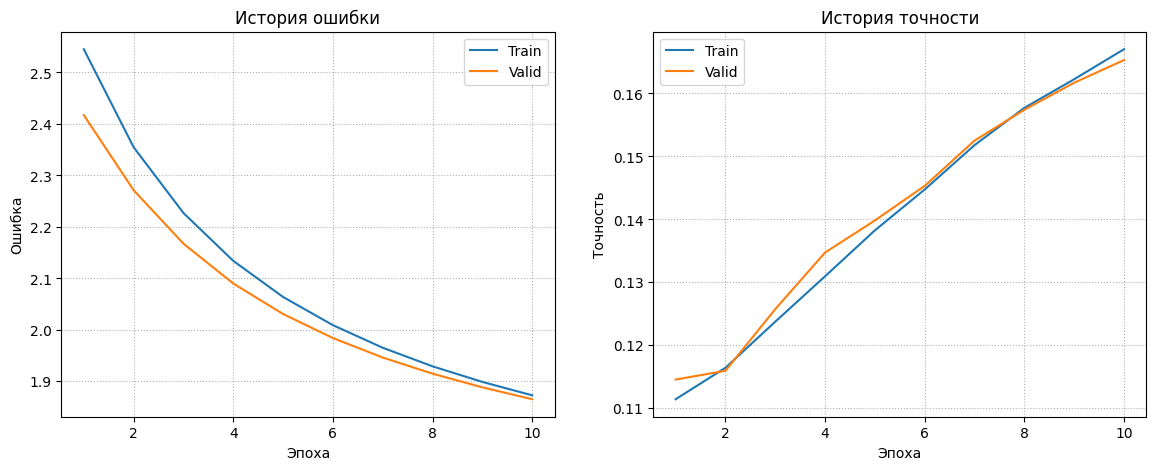

In [47]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [45]:
test_dataloader = Dataloader(test_data, len(test_data), False)
relu_model.eval()
for vecs, labels in test_dataloader:
    out = relu_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.8641
Точность на тесте: 0.1645


In [46]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.24      0.17      0.20      1000
           1       0.15      0.21      0.18      1000
           2       0.12      0.05      0.07      1000
           3       0.11      0.12      0.11      1000
           4       0.18      0.15      0.16      1000
           5       0.18      0.13      0.15      1000
           6       0.14      0.21      0.17      1000
           7       0.14      0.16      0.15      1000
           8       0.24      0.20      0.22      1000
           9       0.20      0.23      0.21      1000

    accuracy                           0.16     10000
   macro avg       0.17      0.16      0.16     10000
weighted avg       0.17      0.16      0.16     10000



##### Вывод  


### Эксперимент 2 Построение нейронной сети с Sigmoid функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.    

Построим простую трехслойную модель

In [48]:
np.random.seed(42)

In [49]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    Sigmoid(),
    Linear(128, 20),
    Sigmoid(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	Sigmoid(),
	Linear(128, 20, bias=True),
	Sigmoid(),
	Linear(20, 10, bias=True)
)

In [50]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ''} пройдена")

Epoch progress: [>                                                 ] 5133/393216 270s>20482s

KeyboardInterrupt: 

In [ ]:
# реальная модель
sigmoid_model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 64),
    Sigmoid(),
    Linear(64, 10)
)
sigmoid_model

In [ ]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=sigmoid_model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    optim_method="GD")

In [ ]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
relu_model.eval()
for vecs, labels in test_dataloader:
    out = sigmoid_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

### Эксперимент 3 Построение нейронной сети с TanH функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

### Эксперимент 4 Построение нейронной сети с Dropout слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  Подберите оптимальную вероятность в dropout. 

### Эксперимент 5 Построение нейронной сети с Batchnorm слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

### Эксперимент 6 Эксперимент с Adam оптимизатором 

Обучите вашу нейронную сеть с Adam оптимизатором. Подбор гиперпараметров на ваше усмотрение. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

### Эксперимент 7 Эксперимент c количеством слоев

Зафиксируйте модель и начинайте добавлять слои. Как меняется качество модели?

### Эксперимент 8 Эксперимент c количеством нейронов

Зафиксируйте модель и увеличьте количетсво весов в одном из слоев. Дает ли это прирост качества?

### Эксперимент 9 Эксперимент c размером батча

Зафиксируйте модель и обучитесь на разных размерах. Как размер батча влияет на процесс обучения?

### Эксперимент 10 Эксперимент с регуляризацией

Добавьте в процесс обучения L1/L2 регуляризацию. Повлияло ли это на качесвто? Выведите норму весов без регуляризации и с. 

### Эксперимент 11 Финальная архитектура

Как выглядит ваша финальная модель?